# Factorization Machine

https://medium.com/@datadote/pytorch-matrix-factorization-pictures-code-part-1-abe331317ffb

In [1]:
import multiprocessing
import numpy as np
import pandas as pd

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_DIR = "/content/drive/MyDrive/Recommender System/Week 3/Factorization Machines/ml-latest-small/"


In [4]:
dfm = pd.read_csv(DATA_DIR + "movies.csv")
df = pd.read_csv(DATA_DIR + "ratings.csv")
df = df.merge(dfm, on="movieId", how="left")
df = df.sort_values(["userId", "timestamp"], ascending=[True, True]).reset_index()
df.head()

,index,userId,movieId,rating,timestamp,title,genres
0,43,1,804,4.0,964980499,She's the One (1996),Comedy|Romance
1,73,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,120,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama
3,171,1,2628,4.0,964980523,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
4,183,1,2826,4.0,964980523,"13th Warrior, The (1999)",Action|Adventure|Fantasy


In [5]:
df["rating"].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [6]:
label_encoder = defaultdict(LabelEncoder)
cols_cat = ["userId", "movieId"]
for c in cols_cat:
  label_encoder[c].fit(df[c].unique())
  df[c] = label_encoder[c].transform(df[c])

df.head()

,index,userId,movieId,rating,timestamp,title,genres
0,43,0,632,4.0,964980499,She's the One (1996),Comedy|Romance
1,73,0,910,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,120,0,1492,5.0,964980523,Bambi (1942),Animation|Children|Drama
3,171,0,1978,4.0,964980523,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
4,183,0,2125,4.0,964980523,"13th Warrior, The (1999)",Action|Adventure|Fantasy


In [7]:
df.drop(["index"], axis=1, inplace=True)
df.head(2)

,userId,movieId,rating,timestamp,title,genres
0,0,632,4.0,964980499,She's the One (1996),Comedy|Romance
1,0,910,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


In [8]:
df_train = df.groupby('userId').head(-5).reset_index(drop=True)
df_val = df.groupby('userId').tail(5).reset_index(drop=True)

In [9]:
class MovieDataset(Dataset):
  def __init__(self, df):
    super().__init__()
    self.df = df[["userId", "movieId", "rating"]]
    self.x_user_movie = list(zip(df.userId.values, df.movieId.values))
    self.y_rating = self.df.rating.values

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return self.x_user_movie[idx], self.y_rating[idx]

In [10]:
NUM_WORKERS = multiprocessing.cpu_count()

In [11]:
BATCH_SIZE = 8192
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)

dl_train = DataLoader(ds_train, BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
dl_val = DataLoader(ds_val, BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

xb, yb = next(iter(dl_train))
print(xb)
print(yb)

[tensor([559, 601, 307,  ..., 369, 201, 510]), tensor([6625,  660, 2670,  ..., 2224, 2037, 8618])]
tensor([2.5000, 4.0000, 1.0000,  ..., 4.5000, 4.0000, 4.0000],
       dtype=torch.float64)


### Create Matrix Factorization Model

In [17]:
class MatrixFactorization(nn.Module):
  """
  Matrix Factorization model
  """
  def __init__(self, num_users, num_items, emb_dim):
    super().__init__()
    self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
    self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)

  def forward(self, user, item):
    user_emb = self.user_emb(user)
    item_emb = self.item_emb(item)
    element_product = (user_emb * item_emb).sum(1)
    return element_product

n_users = len(df.userId.unique())
n_items = len(df.movieId.unique())
model = MatrixFactorization(n_users, n_items, emb_dim = 32)
print(model)

MatrixFactorization(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [19]:
model.to(device)

MatrixFactorization(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
)

In [20]:
LEARNING_RATE = 0.01
NUM_EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
  train_losses, val_losses = [], []
  model.train()
  for xb, yb in dl_train:
    xUser = xb[0].to(device, dtype=torch.long)
    xItem = xb[1].to(device, dtype=torch.long)
    yRatings = yb.to(device, dtype=torch.float)

    preds = model(xUser, xItem)
    loss = loss_fn(preds, yRatings)

    train_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  for xb, yb in dl_val:
    xUser = xb[0].to(device, dtype=torch.long)
    xItem = xb[1].to(device, dtype=torch.long)
    yRatings = yb.to(device, dtype=torch.float)
    preds = model(xUser, xItem)
    loss = loss_fn(preds, yRatings)
    val_losses.append(loss.item())

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_losses.append(epoch_train_loss)
  epoch_val_losses.append(epoch_val_loss)
  print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')


Epoch: 0, Train Loss: 43.9, Val Loss:43.9
Epoch: 1, Train Loss: 35.6, Val Loss:40.5
Epoch: 2, Train Loss: 29.9, Val Loss:37.8
Epoch: 3, Train Loss: 25.5, Val Loss:35.5
Epoch: 4, Train Loss: 22.2, Val Loss:33.7
Epoch: 5, Train Loss: 19.7, Val Loss:32.2
Epoch: 6, Train Loss: 17.6, Val Loss:30.9
Epoch: 7, Train Loss: 15.9, Val Loss:29.7
Epoch: 8, Train Loss: 14.4, Val Loss:28.6
Epoch: 9, Train Loss: 13.0, Val Loss:27.6
Epoch: 10, Train Loss: 11.7, Val Loss:26.5
Epoch: 11, Train Loss: 10.4, Val Loss:25.4
Epoch: 12, Train Loss: 9.1, Val Loss:24.2
Epoch: 13, Train Loss: 7.8, Val Loss:22.9
Epoch: 14, Train Loss: 6.6, Val Loss:21.6
Epoch: 15, Train Loss: 5.5, Val Loss:20.3
Epoch: 16, Train Loss: 4.6, Val Loss:19.2
Epoch: 17, Train Loss: 3.9, Val Loss:18.1
Epoch: 18, Train Loss: 3.3, Val Loss:17.2
Epoch: 19, Train Loss: 2.8, Val Loss:16.4
Epoch: 20, Train Loss: 2.5, Val Loss:15.7
Epoch: 21, Train Loss: 2.2, Val Loss:15.1
Epoch: 22, Train Loss: 1.9, Val Loss:14.6
Epoch: 23, Train Loss: 1.7, Val 

In [21]:
user_emb_min_w = model.user_emb.weight.min().item()
user_emb_max_w = model.user_emb.weight.max().item()
item_emb_min_w = model.item_emb.weight.min().item()
item_emb_max_w = model.item_emb.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])

Emb user min/max w: -3.139 / 3.070
Emb item min/max w: -4.265 / 4.226
Preds min/max: -14.65 / 20.86
Rating min/max: 0.50 / 5.00
[ 0.8676874   3.6243312   0.48563278  2.4834402   2.5709872  -0.04844248]
[3.5 5.  4.  4.5 5.  4. ]


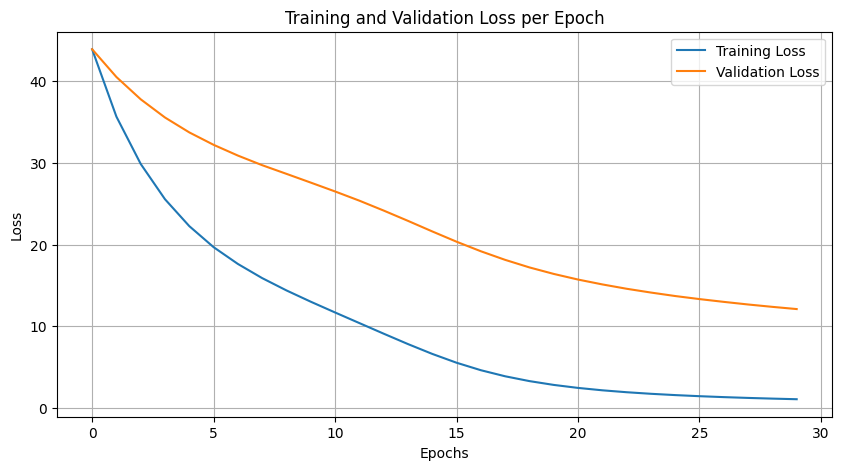

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
